In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123

/Users/elenag/Desktop/PlotterLEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 04082021


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return dot_product # angle*180/3.14159265


angleFromNuMITarget(1,1,1,1.4,3.)

-0.29381557377862155

In [13]:
tree = "NeutrinoSelectionFilter"


#new
BNB  = 'fullDataSets/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = 'fullDataSets/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = 'fullDataSets/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
DRT  = 'fullDataSets/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND


mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [mc,ext,data,dirt] 


variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton", "nu_e", 
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
    ]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = variables + varMC + WEIGHTS + SYSTEMATICS
mc_var   = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC
data_var = variables
ext_var  = variables


# This needs modifications (add variables from above)
uproot_v = [mc,ext,data,dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        mc = CVDF
    elif ii == 1:
        ext = CVDF
    elif ii == 2:
        data = CVDF
    else:
        dirt =  CVDF

['interaction', 'pion_e', 'slnunhits', 'sub', 'CosmicIP', 'evt', 'run', 'npion', 'evnunhits', 'nu_pdg', 'reco_nu_vtx_x', 'trk_llr_pid_score_v', 'reco_nu_vtx_sce_y', 'topological_score', 'CosmicIPAll3D', 'true_e_visible', 'nproton', '_opfilter_pe_beam', 'ccnc', 'category', 'nslice', 'pi0truth_elec_etot', 'slclustfrac', 'theta', 'npi0', 'reco_nu_vtx_sce_z', '_opfilter_pe_veto', 'pi0_e', 'isVtxInFiducial', 'slpdg', 'slnhits', 'muon_e', 'flash_pe', 'backtracked_pdg', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_y', 'CosmicDirAll3D', 'nu_e', 'mc_pdg', 'reco_nu_vtx_z']


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Weights

In [14]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [15]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    '''
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    '''


In [16]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


In [18]:
df_v = [mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
    
    # Cray cray weight fix
    #for ievt in range(df.shape[0]):
    #    reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
    #                         (df['weightsGenie'].iloc[ievt] == np.inf))
    #    df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [19]:
df_v = [mc,dirt,data,ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

# Adding variables

In [20]:
for i,df in enumerate(df_v):
    df['muon_Angle_Numi_Theta'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['muon_theta'],x['muon_phi']) , axis=1)
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

data["bnbdata"] = np.ones_like(data["isVtxInFiducial"])
ext["extdata"] = np.ones_like(ext["isVtxInFiducial"])

In [ ]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)
        
    print(len(listPx), df.shape)
    df['shr_p']       = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    ##########################################
    df['dir_mu_px']  = df['shr_px']/df['shr_p']
    df['dir_mu_py']  = df['shr_py']/df['shr_p']
    df['dir_mu_pz']  = df['shr_pz']/df['shr_p']
    
    df['nu_reco_px']  = listPx
    df['nu_reco_py']  = listPy
    df['nu_reco_pz']  = listPz
    df['BNBP']     = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'] + df['nu_reco_pz']*df['nu_reco_pz'])
    df['BNBPt']    = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'])
    df['BNBTheta'] = np.arccos(df['nu_reco_pz']/df['BNBP'] )
    df['BNBPhi']   = np.arctan2(df['nu_reco_py'],df['nu_reco_px'])
    df['nu_Angle_Numi_Theta'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['BNBTheta'],x['BNBPhi']) , axis=1)
    df['cosNu_Angle_Numi_Theta'] = np.cos(df['nu_Angle_Numi_Theta'])
    df['NuMIPt'] = df['BNBP'] * (np.sin(df['nu_Angle_Numi_Theta']))
    df['checkPt']  = df['BNBPt'] - df['pt']
        

# Event Categories

In [21]:
data["is_signal"] = data["category"] == 11
mc["is_signal"]   = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"]  = ext["category"] == 11

# Selection

In [52]:
# numu selection                                                                                                                                                                                                              
NUMUPRESEL = 'nslice == 1'
NUMUPRESEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMUPRESEL += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251. '
NUMUPRESEL += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110. '
NUMUPRESEL += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986. '

NUMUPRESEL2 = NUMUPRESEL + ' and topological_score > 0.06 '

NUMUSEL = NUMUPRESEL2 + ' and n_muons_tot > 0'


In [72]:
# numu selection                                                                                                                                                                                                              
DIRTSEL = 'nslice == 1'
DIRTSEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
DIRTSEL += ' and (reco_nu_vtx_sce_x < 10 ) '
#DIRTSEL += ' and (reco_nu_vtx_sce_y < -110 or reco_nu_vtx_sce_y > 110.) '
#DIRTSEL += ' and (reco_nu_vtx_sce_z < 20 or reco_nu_vtx_sce_z > 986.) '

#DIRTSEL = NUMUPRESEL + ' and topological_score < 0.06 '



# Plotting part

In [66]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py'>

In [67]:
# muon selection
QUERY = NUMUPRESEL #NUMUSEL #'nslice == 1'


In [68]:
'''
df_v = [mc]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1
'''

"\ndf_v = [mc]\nfor i,df in enumerate(df_v):\n    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12\n    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1\n    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1\n"

In [137]:
import plotter
import importlib
importlib.reload(plotter)

nue = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)") 
samples = {
    "mc"  : mc,
    "nue" : nue,
    "data": data,
    #"dirt": dirt,
    "ext" : ext
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22    
dirtratio = pot/1.42143e+21
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98
scalingDRT = 0.60 #0.35

weights = { "mc"  : mcratio  * SPLIT * scaling,
            "nue"  : mcratio  * SPLIT * scaling,
            "ext" : extratio * SPLIT * scalingEXT,    
            #"dirt": dirtratio* SPLIT * scalingDRT,   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.08559738414394057, 'nue': 0.08559738414394057, 'ext': 0.5612087579382191}


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:239: UserWarning: Missing dirt sample
  #"backtracked_pdg", "nu_pdg", "ccnc", "trk_bkt_pdg", "shr_bkt_pdg"]


nu_pdg == 14 and nslice >= 0& neutrino_energy <= 4 & neutrino_energy >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:457: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


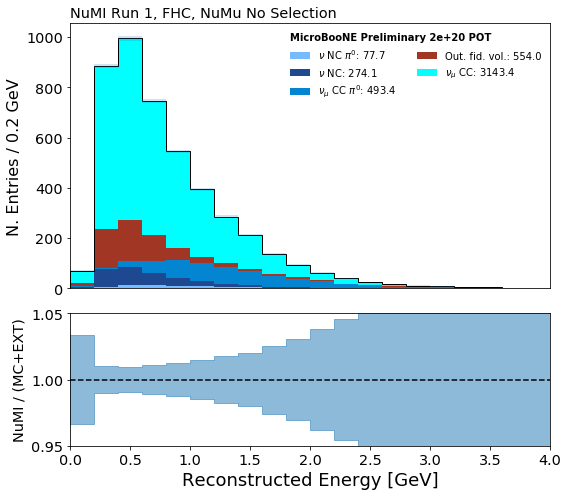

In [153]:
# numu selection                                                                                                                                                                                                              
DIRTSEL = 'nslice == 1'
DIRTSEL += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
DIRTSEL += ' and (reco_nu_vtx_sce_x < 3 ) '
#DIRTSEL += ' and (reco_nu_vtx_sce_y < -110 ) ' #or reco_nu_vtx_sce_y > 110.
#DIRTSEL += ' and (reco_nu_vtx_sce_z < 2 or reco_nu_vtx_sce_z > 1030.) '

#DIRTSEL = NUMUPRESEL + ' and topological_score < 0.06 '


QUERY = "nu_pdg == 14 and nslice >= 0" #DIRTSEL
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False


VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',100,(100,120),"vtx y [cm]"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',100,(1030,1050),"vtx z [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',100,(250,270),"vtx x [cm]" 

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',100,(-10,2),"vtx z [cm]"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',100,(-120,-100),"vtx y [cm]"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',100,(0,5),"vtx x [cm]" 

VARIABLE, BINS, RANGE, XTIT = 'n_tracks_tot',1,(0,10),"N track "
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',20,(0., 4.0),"Reconstructed Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'nu_e',20,(0., 4.0),"True Energy [GeV]"
#VARIABLE, BINS, RANGE, XTIT = 'nslice',2,(0,2),"nslice [GeV]"


fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = False, 
    draw_geoSys = False, 
    draw_data = False,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, NuMu 1eNp -- GENIE + PPFX Only',loc='left')
ax1.set_title('NuMI Run 1, NuMu Sel -- Stat Only',loc='left')

ax1.set_title('NuMI Run 1, FHC, AntiNuMu No Selection',loc='left')
ax1.set_title('NuMI Run 1, FHC, NuMu No Selection',loc='left')
ax2.set_ylim(0.95,1.05)

fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/NearSideband/"+VARIABLE+"_minedge_dirt_run1.pdf")

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and topological_score > 0.06  and n_muons_tot > 0& muon_momentum <= 2 & muon_momentum >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:255: RuntimeWarning: invalid value encountered in true_divide
  
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2164: RuntimeWarning: invalid value encountered in true_divide
  ratio_error_mc = self._ratio_err(n_tot, n_tot, tot_err, np.zeros(len(n_tot)))


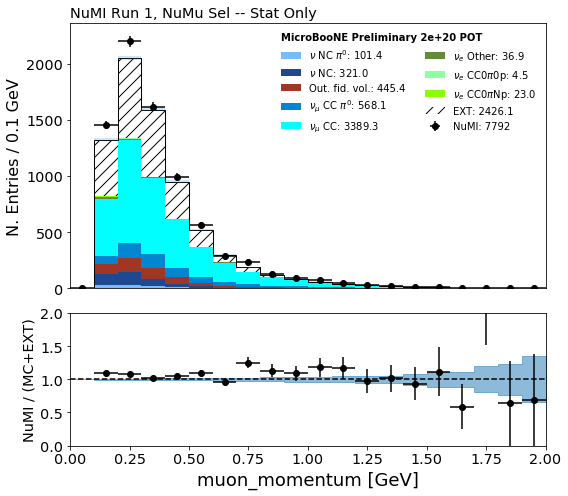

In [143]:
QUERY = NUMUSEL + " and n_protons_tot > 0"
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(0,10),"N track contained "
#VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.0, 1.50),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(0,10),"N track contained "
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_tot',10,(0,10),"N track "

VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'muon_Angle_Numi_Theta',20,(-0.8,1),"cos Beta"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',26,(0,260),"vtx x [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',50,(0,1000),"vtx z [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',24,(-120,120),"vtx y [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'topological_score',25,(0,1),"topological score"
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"

QUERY =  NUMUSEL #NUMUPRESEL #'nslice == 1'
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = systematicsBool, 
    draw_geoSys = False, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, NuMu 1eNp -- GENIE + PPFX Only',loc='left')
ax1.set_title('NuMI Run 1, NuMu Sel -- Stat Only',loc='left')

fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/NearSideband/"+VARIABLE+"_numu_run1.pdf")

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and topological_score > 0.06  and n_muons_tot > 0& muon_momentum <= 2 & muon_momentum >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


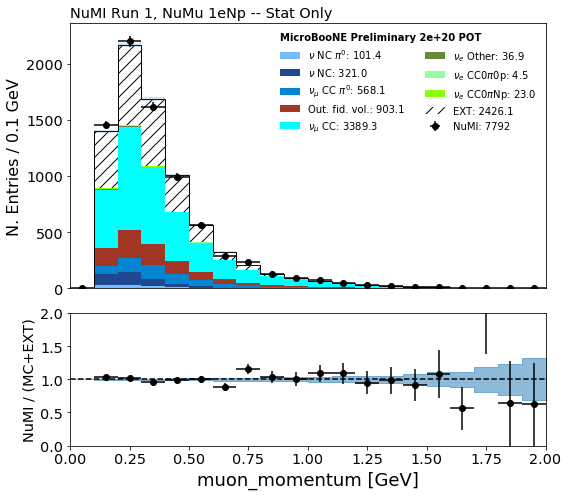

In [131]:
QUERY = NUMUSEL #+ " and n_protons_tot > 0"
import matplotlib.pyplot as plt
import matplotlib

systematicsBool = False

VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(0,10),"N track contained "
#VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.0, 1.50),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_contained',10,(0,10),"N track contained "
VARIABLE, BINS, RANGE, XTIT = 'n_tracks_tot',10,(0,10),"N track "

VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'muon_Angle_Numi_Theta',20,(-0.8,1),"cos Beta"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',26,(0,260),"vtx x [cm]" 

VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',50,(0,1000),"vtx z [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',24,(-120,120),"vtx y [cm]" 
VARIABLE, BINS, RANGE, XTIT = 'topological_score',25,(0,1),"topological score"

VARIABLE, BINS, RANGE, XTIT = 'neutrino_energy',14,(0.15, 1.55),"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'muon_momentum',20,(0,2),"muon_momentum [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = systematicsBool, 
    draw_geoSys = False, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, NuMu 1eNp -- Stat Only',loc='left')
#ax1.set_title('NuMI Run 1, NuMu Sel -- Stat Only',loc='left')

fig.tight_layout()
fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/NearSideband/"+VARIABLE+"_numu_run1_NP.pdf")